In [6]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os

from model import *
from utils import *
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [7]:
def load_model(model, exp_name, ckpt=0, final=False, best=False, file_name=None):
    if file_name:
        fn = file_name
    elif best:
        fn = 'best-model.pth'
    elif final:
        fn = 'final-model.pth'
    else:
        fn = f'checkpoint-{ckpt}.pth'
    model_path = f'/mnt/cfs/sihaozhe/ss-dfd/exp/{exp_name}/model/{fn}'
    model_dict = torch.load(model_path)
    state_dict = model_dict['model']
    model.load_state_dict(state_dict)
    return model_dict['iter']

In [8]:
def dpt_post_op(dpt, post_op, near=0.1, far=10.):
    if post_op == 'clip':
        dpt = torch.clip(dpt, 0, 1).detach().cpu()
    elif post_op == 'norm':
        dpt_local_min = torch.min(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        dpt_local_max = torch.max(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        norm_dpt_ = dpt / (dpt_local_max + 1e-8)
        # norm_dpt_ = (dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
        norm_dpt = norm_dpt_ * (far - near) + near
        dpt = norm_dpt.detach().cpu()
    return dpt

In [9]:
data_path = "/mnt/cfs/sihaozhe/data/NYUv2"
device = 2
BS = 1
use_cuda = True

In [10]:
trans = True
if trans:
    fd = [2, 3, 4.5, 5, 7]
else:
    fd = [1, 1.5, 2.5, 4, 6]

In [11]:
dataset_config = {
        'root_dir': data_path,
        'shuffle': False,
        'img_num':  5, 
        'visible_img': 5,
        'focus_dist': fd,
        'recon_all': True,
        'RGBFD': True,
        'DPT': True,
        'AIF': True,
        'near': 0.1,
        'far':10.,
        'scale':1,
        'trans' : trans
    }

In [12]:
torch.cuda.set_device(device)

In [13]:
camera = ThinLenCamera(fnumber=1.2, focal_length=17*1e-3, pixel_size=1.2e-5)
render = GaussPSF(7)
render.cuda()
model = FUNet(4, 4)

In [14]:
train_dl, _, test_dl = load_data(dataset_config, "NYUv2", BS)

5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


In [15]:
best=True
post_op = 'norm'
model_name = 'NYU_100_max_fuse_full'
upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

In [16]:
idx = 4
sample = test_dl.dataset[idx]

In [17]:
exp_name = f'{model_name}'
n_iter = load_model(model, exp_name, best=best)
model = model.cuda()
FS, C, H, W = sample['output'].shape
with torch.no_grad():
    raw_aif_dpt = model(sample['rgb_fd'][[0, 1, 3, 4]].unsqueeze(0).cuda())
    raw_aif = raw_aif_dpt[:, :-1]
    raw_dpt = raw_aif_dpt[:, -1]
pred_dpt = dpt_post_op(raw_dpt, post_op)
fd_dpt = pred_dpt.expand(FS, H, W)
pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
pred_aif = torch.clip(raw_aif, 0, 1)
dpt_gt = sample['dpt'].numpy()[0]
aif_gt = sample['aif'].numpy().transpose(1, 2, 0)

In [18]:
focal_stack = sample['rgb_fd'].numpy()[:, :-1].transpose(0, 2, 3, 1)
fds = sample['output_fd'].view(-1, 1, 1).expand_as(fd_dpt)
defocus = camera.getCoC(fd_dpt, fds)

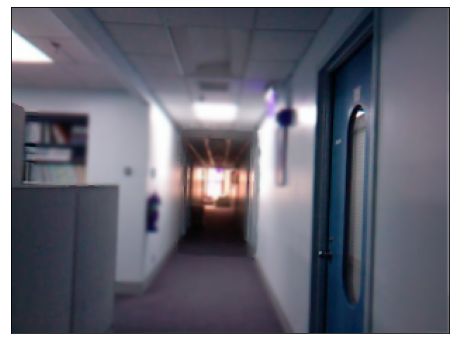

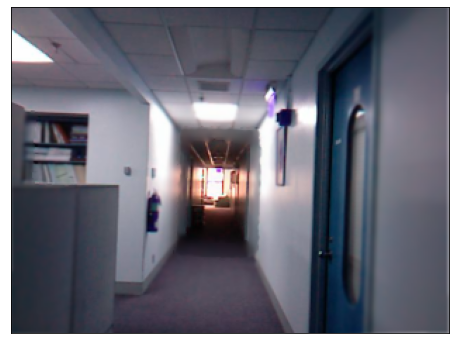

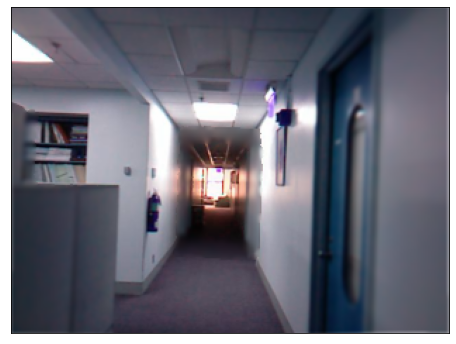

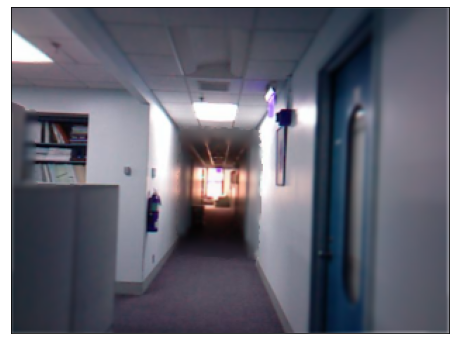

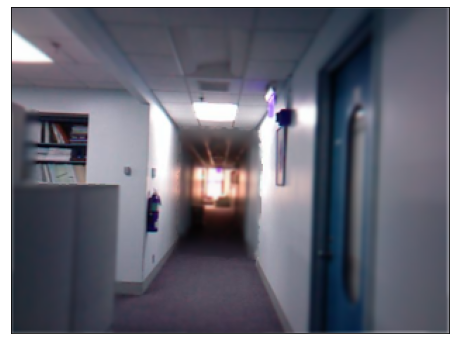

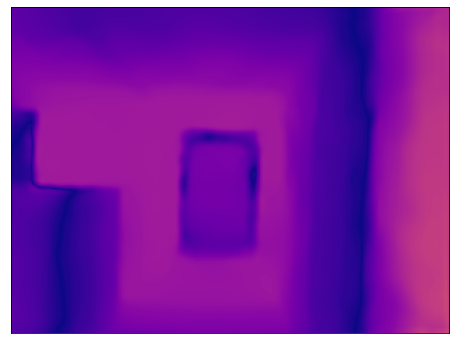

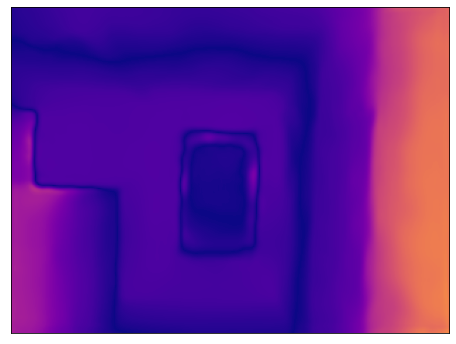

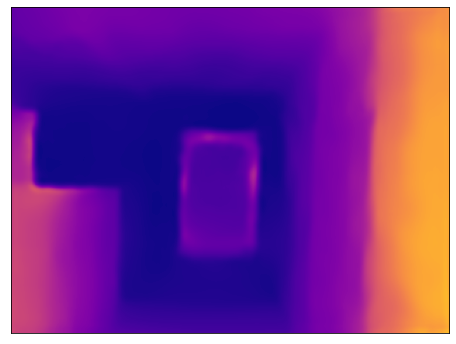

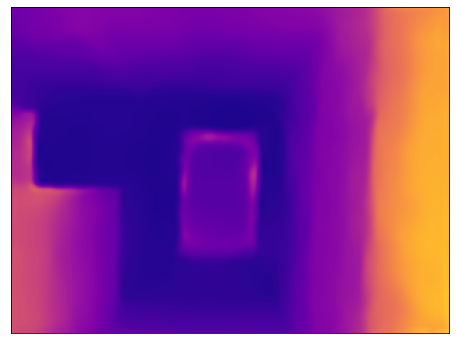

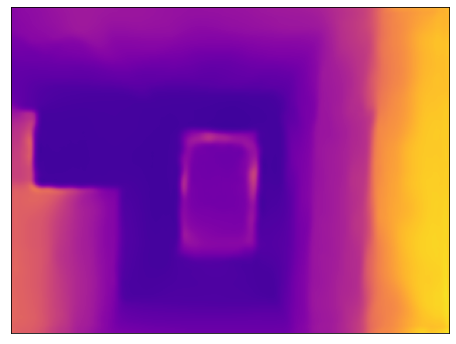

In [19]:
# fig = plt.figure(figsize=(20, 6))
fs_list = [focal_stack, defocus]
for i in range(2):
    for j in range(5):
        # plt.subplot(2, 5, i * 5 + j + 1)
        plt.figure(figsize=(10, 6))
        if i == 0:
            plt.imshow(fs_list[i][j][4:-4, 4:-4])
        else:
            plt.imshow(fs_list[i][j][4:-4, 4:-4], cmap='plasma', vmin=0, vmax=8)
        plt.xticks([])
        plt.yticks([])
        # plt.colorbar()
        # plt.savefig(f'paper_img/{i}-fd{fd[j]}.png')

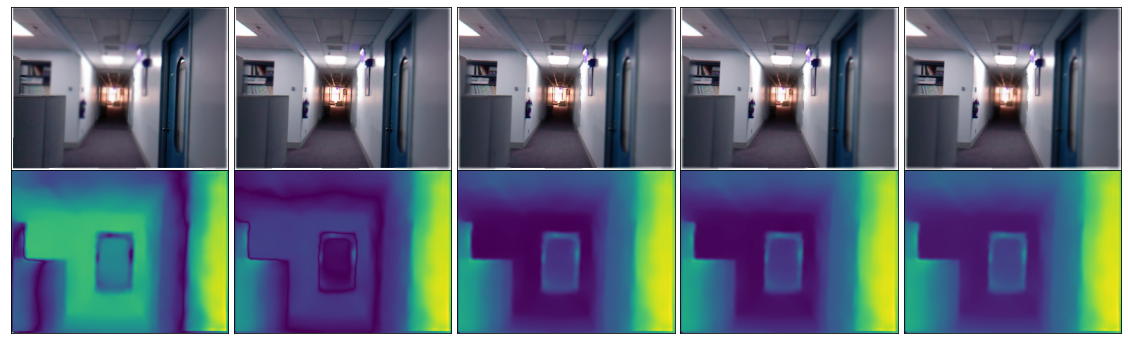

In [22]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(2, 5, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')

fs_list = [focal_stack, defocus]
for i in range(2):
    for j in range(5):
        if i == 0:
            axs[i, j].imshow(fs_list[i][j])
        else:
            axs[i, j].imshow(fs_list[i][j])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
# for ax in axs.flat:
#     ax.label_outer()
# fig.tight_layout()

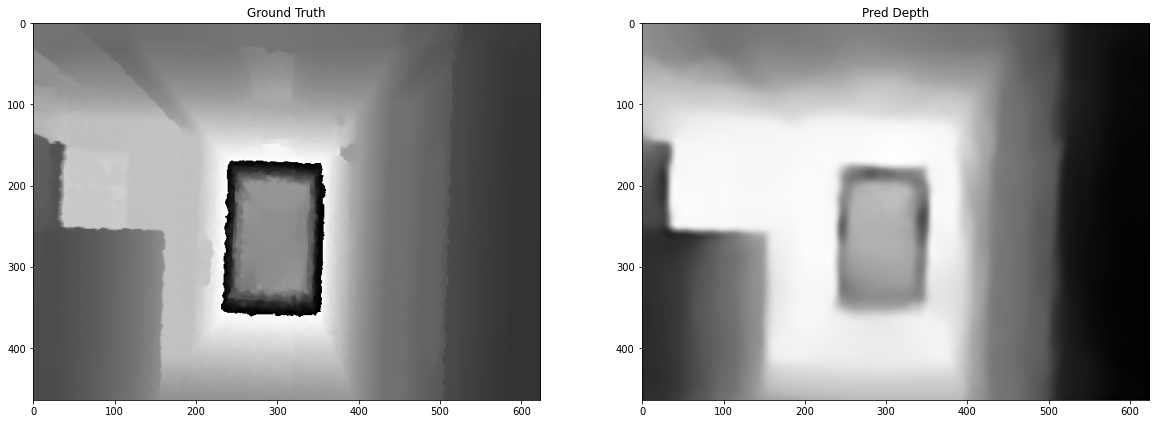

In [23]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(dpt_gt[8:-8, 8:-8], cmap='Greys_r')
plt.subplot(1, 2, 2)
plt.title('Pred Depth')
plt.imshow(pred_dpt[0].cpu().numpy()[8:-8, 8:-8], cmap='Greys_r')

In [24]:
dpt_gt.shape

(480, 640)

In [ ]:
256 320
128 160
64 80
32 40
16 20


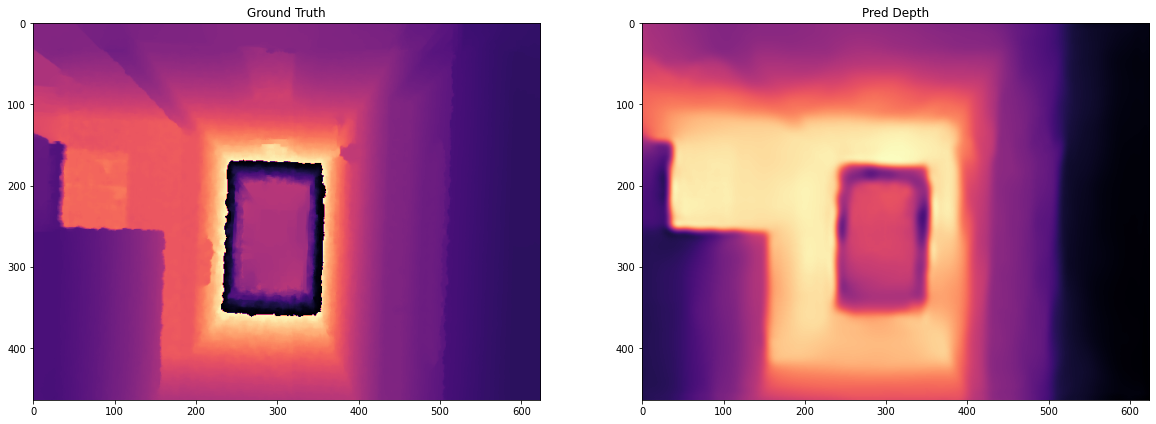

In [89]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(dpt_gt[8:-8, 8:-8], cmap='magma')
# plt.imshow(dpt_gt, cmap='magma', vmin=0, vmax=10)
plt.subplot(1, 2, 2)
plt.title('Pred Depth')
plt.imshow(pred_dpt[0].cpu().numpy()[8:-8, 8:-8], cmap='magma')
# plt.imshow(pred_dpt[0].cpu().numpy(), cmap='magma', vmin=0, vmax=10)

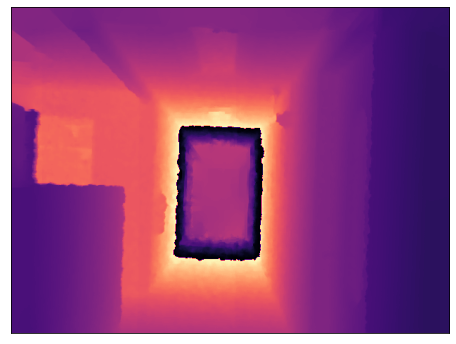

In [90]:
plt.figure(figsize=(10, 6))
plt.imshow(dpt_gt[8:-8, 8:-8], cmap='magma')
plt.xticks([])
plt.yticks([])
plt.savefig('paper_img/gt_dpt.png')

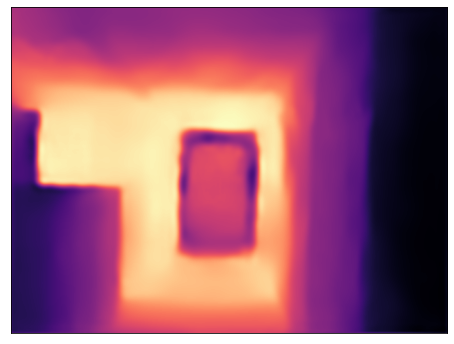

In [91]:
plt.figure(figsize=(10, 6))
plt.imshow(pred_dpt[0].cpu().numpy()[4:-4, 4:-4], cmap='magma')
plt.xticks([])
plt.yticks([])
plt.savefig('paper_img/pred_dpt.png')

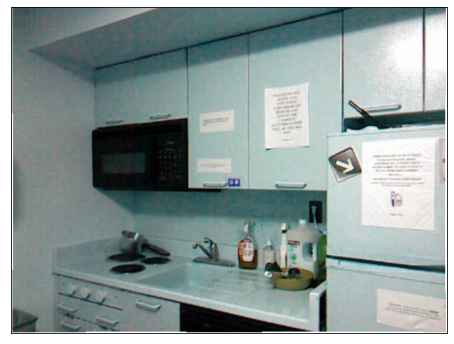

In [78]:
plt.figure(figsize=(10, 6))
plt.imshow(aif_gt[4:-4, 4:-4])
plt.xticks([])
plt.yticks([])
plt.savefig('paper_img/gt_aif.png')

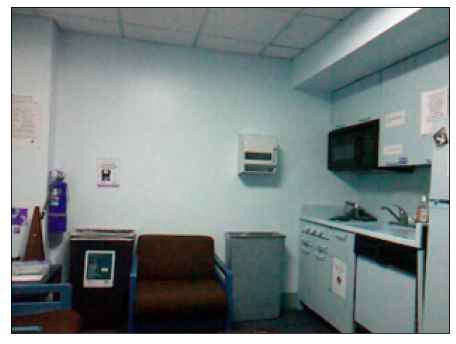

In [66]:
plt.figure(figsize=(10, 6))
plt.imshow(pred_aif[0].cpu().numpy().transpose(1, 2, 0)[4:-4, 4:-4])
plt.xticks([])
plt.yticks([])
plt.savefig('paper_img/pred_aif.png')

In [67]:
FS, C, H, W = sample['output'].shape
inp_fs = sample['rgb_fd'][[0, 1, 3, 4], :-1]
clear_idx = torch.argmin(defocus[[0, 1, 3, 4]].view(4, 1, H, W).expand(4, C, H, W), dim=0, keepdim=True)
coarse_aif = torch.gather(inp_fs, 0, clear_idx)

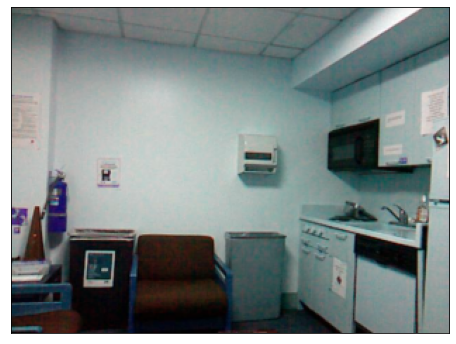

In [68]:
plt.figure(figsize=(10, 6))
plt.imshow(coarse_aif[0].cpu().numpy().transpose(1, 2, 0)[4:-4, 4:-4])
plt.xticks([])
plt.yticks([])
plt.savefig('paper_img/coarse_aif.png') 

In [23]:
render = GaussPSF(7)

In [24]:
fs_aif = pred_aif.expand(5, C, H, W).contiguous().view(5, C, H, W)

In [25]:
recon = render(fs_aif.cuda(), defocus.cuda()).detach().cpu().numpy().transpose(0, 2, 3, 1) # FS C H W

In [26]:
recon.shape

(5, 240, 320, 3)

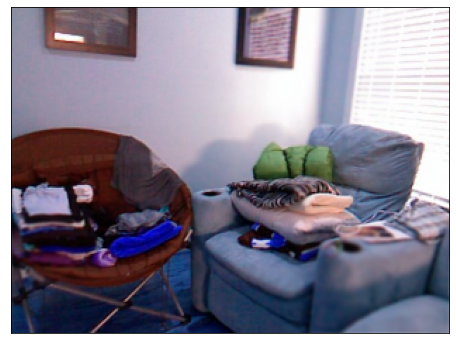

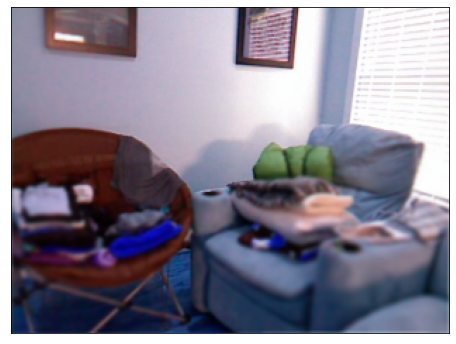

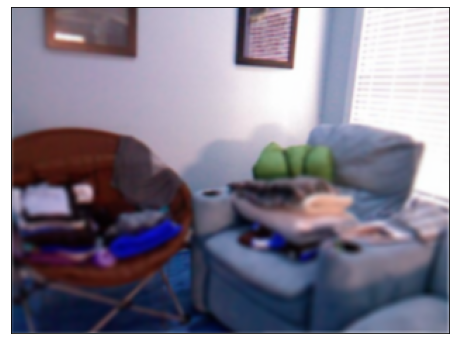

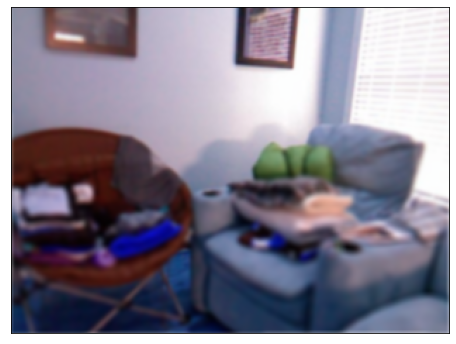

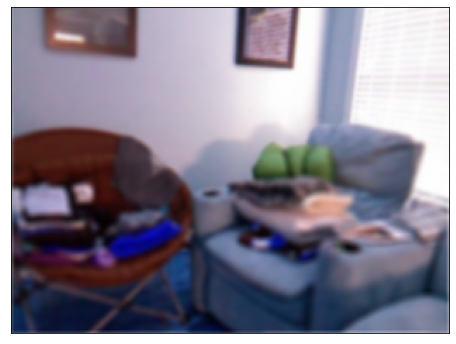

In [27]:
# fig =  plt.figure(figsize=(20, 6))
for j, img in enumerate(recon):
    # plt.subplot(2, 5, i * 5 + j + 1)
    plt.figure(figsize=(10, 6))
    plt.imshow(img[4:-4, 4:-4])
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'paper_img/2-fd{fd[j]}.png')

In [80]:
df_fs = pd.read_csv('FS_exp.csv')
df_fs

Setting  n_img    AbsRel      RMSE    delta1    delta2    delta3  \
0   NYU100_FS3      1  0.656655  1.204578  0.346412  0.620115  0.811164   
1   NYU100_FS5      1  0.689094  1.246112  0.333672  0.605840  0.799298   
2   NYU100_FS7      1  0.505904  1.091075  0.384863  0.674428  0.847618   
3   NYU100_FS3      2  0.292052  0.667339  0.770194  0.893874  0.950561   
4   NYU100_FS5      2  0.329784  0.737045  0.716860  0.876345  0.943463   
5   NYU100_FS7      2  0.327419  0.780798  0.690809  0.856122  0.935941   
6   NYU100_FS3      3  0.269267  0.495430  0.869207  0.940392  0.959624   
7   NYU100_FS5      3  0.283548  0.501611  0.858146  0.936618  0.957143   
8   NYU100_FS7      3  0.309503  0.536501  0.849472  0.937904  0.958860   
9   NYU100_FS3      4  0.285706  0.556823  0.771823  0.972551  0.986055   
10  NYU100_FS5      4  0.258335  0.479276  0.842343  0.974339  0.986515   
11  NYU100_FS7      4  0.270941  0.489618  0.880160  0.967576  0.979457   
12  NYU100_FS3      5  0.272351  0.522170  0.809814  0.973371  0.986033   
13  NYU100_FS5      5  0.238128  0.425946  0.880488  0.977201  0.986491   
14  NYU100_FS7      5  0.255904  0.441755  0.906377  0.969500  0.978064   
15  NYU100_FS3      6  0.270365  0.453780  0.885552  0.943093  0.958548   
16  NYU100_FS5      6  0.257411  0.407532  0.906091  0.948452  0.960556   
17  NYU100_FS7      6  0.289129  0.429212  0.908452  0.949952  0.961746   
18  NYU100_FS3      7  0.263080  0.457885  0.865686  0.977809  0.985741   
19  NYU100_FS5      7  0.214427  0.341751  0.945285  0.981168  0.987049   
20  NYU100_FS7      7  0.256512  0.392049  0.923006  0.964370  0.973113   
21  NYU100_FS3      8  0.263080  0.457885  0.865686  0.977809  0.985741   
22  NYU100_FS5      8  0.214427  0.341751  0.945285  0.981168  0.987049   
23  NYU100_FS7      8  0.256512  0.392049  0.923006  0.964370  0.973113   
24  NYU100_FS3      9  0.265735  0.461835  0.855431  0.977641  0.985708   
25  NYU100_FS5      9  0.212165  0.334454  0.947350  0.981104  0.986966   
26  NYU100_FS7      9  0.256593  0.389950  0.927900  0.963358  0.971757   
27  NYU100_FS3     10  0.260177  0.452420  0.874556  0.978228  0.985773   
28  NYU100_FS5     10  0.233795  0.349595  0.935412  0.981632  0.987186   
29  NYU100_FS7     10  0.222783  0.354640  0.935412  0.971823  0.976184   

          SF        MG  
0   0.112094  0.030981  
1   0.117777  0.034379  
2   0.119203  0.033645  
3   0.125645  0.035394  
4   0.128960  0.037980  
5   0.127573  0.037149  
6   0.125224  0.125224  
7   0.127359  0.036241  
8   0.125450  0.035716  
9   0.126244  0.035377  
10  0.128280  0.035934  
11  0.124947  0.034830  
12  0.129721  0.036683  
13  0.131163  0.036985  
14  0.128401  0.036180  
15  0.129512  0.036912  
16  0.130782  0.037420  
17  0.129033  0.036970  
18  0.131665  0.131665  
19  0.133025  0.037798  
20  0.130775  0.037069  
21  0.131665  0.037515  
22  0.133025  0.037798  
23  0.130775  0.037069  
24  0.131757  0.037540  
25  0.133430  0.037997  
26  0.130935  0.037236  
27  0.134647  0.038552  
28  0.135901  0.038867  
29  0.133439  0.037900

In [81]:
import matplotlib.lines as mlines


In [82]:
df_fs = df_fs.loc[df_fs.n_img!=1]


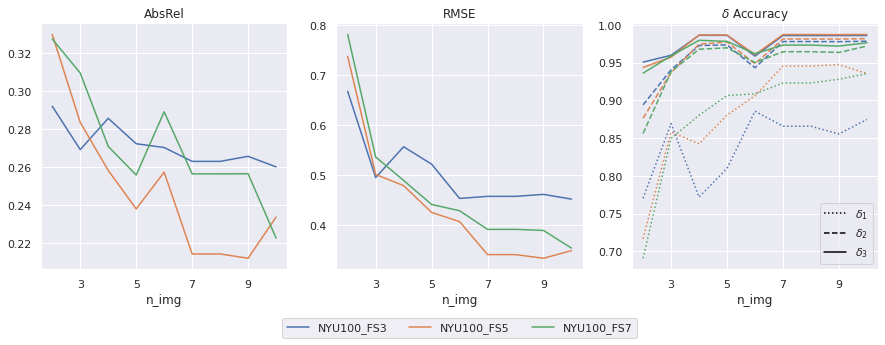

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15,15), sharey=False)

sns.lineplot(data=df_fs, x='n_img', y='AbsRel', hue='Setting', ax=axes[0], legend=False)
sns.lineplot(data=df_fs, x='n_img', y='RMSE', hue='Setting',  ax=axes[1])
sns.lineplot(data=df_fs, x='n_img', y='delta1', hue='Setting',  ax=axes[2], ls=':', legend=False)
sns.lineplot(data=df_fs, x='n_img', y='delta2', hue='Setting',  ax=axes[2], ls='--', legend=False)
sns.lineplot(data=df_fs, x='n_img', y='delta3', hue='Setting',  ax=axes[2], legend=False)

axes[0].set_box_aspect(1)
axes[1].set_box_aspect(1)
axes[2].set_box_aspect(1)
axes[0].set_ylabel('')
axes[0].set_xticks([3, 5, 7, 9])
axes[1].set_ylabel('')
axes[1].set_xticks([3, 5, 7, 9])
axes[2].set_ylabel('')
axes[2].set_xticks([3, 5, 7, 9])
axes[0].set_title('AbsRel')
axes[1].set_title('RMSE')
axes[2].set_title('$\delta$ Accuracy')
axes[1].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.3))

solid_line = mlines.Line2D([], [], color='black', label='$\delta_3$')
dash_line = mlines.Line2D([], [], color='black', ls='--', label='$\delta_2$')
dot_line = mlines.Line2D([], [], color='black', ls=':', label='$\delta_1$')

axes[2].legend(handles=[dot_line, dash_line, solid_line])

plt.show()
